# GPT 2

In [44]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

# Byte Pair Encoding

- GPT-2 used BytePair encoding (BPE) as its tokenizer
- it allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words
- For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges
- The original BPE tokenizer can be found here: [https://github.com/openai/gpt-2/blob/master/src/encoder.py](https://github.com/openai/gpt-2/blob/master/src/encoder.py)
- In this chapter, we are using the BPE tokenizer from OpenAI's open-source [tiktoken](https://github.com/openai/tiktoken) library, which implements its core algorithms in Rust to improve computational performance
- I created a notebook in the [./bytepair_encoder](../02_bonus_bytepair-encoder) that compares these two implementations side-by-side (tiktoken was about 5x faster on the sample text)

In [45]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tokenizer = tiktoken.get_encoding('gpt2')
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)
strings = tokenizer.decode(integers)
print(strings)

tiktoken version: 0.12.0
[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.



---
# Data Sampling with a sliding window

- We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict:


---
# Token Embeddings

- Let us embed the tokens in a continuous vector representation using an embedding layer
- Usually, these embedding layers are part of the LLM itself and are updated (trained) during model training

In [46]:
import torch
import torch.nn as nn

vocab_size = 6
output_dim = 3
input_ids = torch.tensor([2, 3, 5, 1])

torch.manual_seed(123)
embedding_layer = nn.Embedding(vocab_size, output_dim)
print(embedding_layer)
print("Weight Matrix:\n", embedding_layer.weight)
print("Token with id 3:\n", embedding_layer(torch.tensor([3])))
print(embedding_layer(input_ids))

Embedding(6, 3)
Weight Matrix:
 Parameter containing:
tensor([[ 3.3737e-01, -1.7778e-01, -1.6896e-01],
        [ 9.1776e-01,  1.5810e+00,  1.3010e+00],
        [ 1.2753e+00, -2.0095e-01, -1.6056e-01],
        [-4.0149e-01,  9.6657e-01, -1.1481e+00],
        [-1.1589e+00,  3.2547e-01, -6.3151e-01],
        [-2.8400e+00, -7.8485e-01, -1.4096e+00]], requires_grad=True)
Token with id 3:
 tensor([[-4.0149e-01,  9.6657e-01, -1.1481e+00]], grad_fn=<EmbeddingBackward0>)
tensor([[ 1.2753e+00, -2.0095e-01, -1.6056e-01],
        [-4.0149e-01,  9.6657e-01, -1.1481e+00],
        [-2.8400e+00, -7.8485e-01, -1.4096e+00],
        [ 9.1776e-01,  1.5810e+00,  1.3010e+00]], grad_fn=<EmbeddingBackward0>)



---
# Encoding Word Positions

In [47]:
max_length=4
output_dim = 3

context_length = max_length
pos_embedding_layer = nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print("Shape:\n", pos_embeddings.shape)
print(pos_embeddings)

input_embeddings = embedding_layer(input_ids) + pos_embeddings
print(input_embeddings)

Shape:
 torch.Size([4, 3])
tensor([[-6.3068e-01,  1.2340e+00,  3.1268e-01],
        [ 6.9719e-01, -9.9505e-01, -1.1476e+00],
        [-9.1777e-01,  9.0452e-01, -2.0975e+00],
        [ 1.1558e+00, -1.2157e+00,  1.2952e-01]], grad_fn=<EmbeddingBackward0>)
tensor([[ 6.4463e-01,  1.0331e+00,  1.5211e-01],
        [ 2.9570e-01, -2.8477e-02, -2.2958e+00],
        [-3.7578e+00,  1.1966e-01, -3.5071e+00],
        [ 2.0735e+00,  3.6532e-01,  1.4306e+00]], grad_fn=<AddBackward0>)



---
# Masked Multi Head Attention (with weight splits)

In [48]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out # (6)
        self.num_heads = num_heads # (2)
        self.head_dim = d_out // num_heads # (3)

        # Weight Metrices
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias) # (6, 6)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias) # (6, 6)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias) # (6, 6)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape  # (1,3,6)

        # query, key and value metrices
        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)  (1,3,6)
        queries = self.W_query(x)
        values = self.W_value(x)

        # unroll
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)   # (1,3,2,3)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Now group metrices by number of heads, instead of number of tokens
        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1,2)  # (1,2,3,3)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)  # (1,2,3,3)  # (b, num_heads, num_tokens, num_tokens)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) # (1,3,2,3)
        
        # Combine heads (flatten), where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)  # (1,3,6)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec


torch.manual_seed(123)

# Define the tensor with 3 rows and 6 columns
inputs = torch.tensor(
    [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66],  # Row 1
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],  # Row 2
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]]  # Row 3
)

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

batch_size, context_length, d_in = batch.shape
d_out = 6
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

torch.Size([2, 3, 6])
tensor([[[ 1.5692e-01, -8.7313e-02,  2.1006e-02,  2.1526e-02, -3.2431e-01,
          -2.5176e-01],
         [ 1.1170e-01, -5.4734e-02,  4.0633e-02, -2.1268e-02, -3.2512e-01,
          -2.9932e-01],
         [ 1.1956e-01, -4.9084e-02,  3.1778e-02, -6.3516e-02, -2.7884e-01,
          -2.5779e-01]],

        [[ 1.5692e-01, -8.7313e-02,  2.1006e-02,  2.1526e-02, -3.2431e-01,
          -2.5176e-01],
         [ 1.1170e-01, -5.4734e-02,  4.0633e-02, -2.1268e-02, -3.2512e-01,
          -2.9932e-01],
         [ 1.1956e-01, -4.9084e-02,  3.1778e-02, -6.3516e-02, -2.7884e-01,
          -2.5779e-01]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 3, 6])



---
# Layer Normalization

In [49]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var+self.eps)
        return self.scale*norm_x + self.shift

batch_example = torch.randn(2, 5)
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

torch.set_printoptions(sci_mode = False)
print(batch_example)
print("\n\n")
print("Mean and Variance of batch:", batch_example.mean(), batch_example.var())
print("\n\n")
print(out_ln)
print("\n\n")
print("Mean and Variance of Normalized Layer:", out_ln.mean(dim=-1, keepdim=True), out_ln.var(dim=-1, keepdim=True, unbiased=False))

tensor([[-0.6669,  0.5074, -1.1026, -0.3533, -1.7799],
        [ 0.6474,  0.5460,  0.8050, -1.3467, -0.6418]])



Mean and Variance of batch: tensor(-0.3385) tensor(0.8506)



tensor([[ 0.0160,  1.5565, -0.5556,  0.4273, -1.4442],
        [ 0.7616,  0.6419,  0.9476, -1.5915, -0.7597]], grad_fn=<AddBackward0>)



Mean and Variance of Normalized Layer: tensor([[-0.0000],
        [-0.0000]], grad_fn=<MeanBackward1>) tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)



---
# Feed Forward Neural Network with GELU Activation

In [50]:
# GELU with Approximation
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5*x*(1+torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
        )

    def forward(self, x):
        return self.layers(x)


ffnn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffnn(x)
print(out.shape)

torch.Size([2, 3, 768])



---
# Shortcut Connections

In [51]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f'{name} has gradient mean of {param.grad.abs().mean().item()}')



layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut = False
)
print_gradients(model_without_shortcut, sample_input)

print("\n\n")

torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031



layers.0.0.weight has gradient mean of 0.22169798612594604
layers.1.0.weight has gradient mean of 0.20694111287593842
layers.2.0.weight has gradient mean of 0.3289700150489807
layers.3.0.weight has gradient mean of 0.26657330989837646
layers.4.0.weight has gradient mean of 1.3258544206619263



---
# Transformer Block

In [52]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


torch.manual_seed(123)

x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input Shape:", x.shape)
print("Output Shape:", output.shape)

Input Shape: torch.Size([2, 4, 768])
Output Shape: torch.Size([2, 4, 768])



---
# GPT2 Model

In [53]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = nn.LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)


torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input Batch:\n", batch)
print("\nOutput Shape:", out.shape)
print(out)

Input Batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output Shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [54]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total number of parameters: 163,009,536
Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])
Number of trainable parameters considering weight tying: 124,412,160
Total size of the model: 621.83 MB



---
# Generating Text

In [55]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

model.eval()

out =  generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10
Hello, I am Featureiman Byeswickattribute argue


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="600px">


---
# Loss Calculation

In [56]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads  
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

def text_to_token_ids(text, tokenizer):
    encoded  = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you Samoa parad Defensive MacBook Referospace preparation Einstein ShepherdMot


In [57]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [58]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

torch.set_printoptions(sci_mode = True)

text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 2:", target_probas_2)

# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

perplexity = torch.exp(loss)
print(perplexity)

Token IDs:
 tensor([[[ 5873],
         [42899],
         [26729]],

        [[ 9580],
         [24016],
         [16637]]])
Targets batch 1:  effort moves you
Outputs batch 1:  percentage Skinner Theme
Text 1: tensor([4.0363e-05, 2.7361e-05, 1.1445e-05])
Text 2: tensor([8.2989e-06, 9.1948e-05, 6.1120e-06])
tensor([-1.0118e+01, -1.0506e+01, -1.1378e+01, -1.1699e+01, -9.2943e+00,
        -1.2005e+01])
tensor(-1.0833e+01)
tensor(1.0833e+01)
Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
tensor(1.0833e+01)
tensor(5.0689e+04)


In [59]:
import os
import requests

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text_data = response.text
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()


total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [60]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        for i in range(0, len(token_ids)-max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1 : i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256,
                        stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
    return dataloader

In [61]:
train_ratio = 0.9
split_idx = int(train_ratio*len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [62]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")


print("Train Loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train Loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [63]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss=0.
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches

In [64]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")


print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using cuda device.
Training loss: 10.985983424716526
Validation loss: 10.993607521057129



---
# Training an LLM

In [65]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                        eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # calculate loss gradients
            optimizer.step()  # update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                        f"Train loss {train_loss:.3f}, val loss {val_loss:.3f}")
        
        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [66]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effor moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.821, val loss 9.931
Ep 1 (Step 000005): Train loss 8.069, val loss 8.334
Every effor moves you,,,,,,,,,,,,,.                                    
Ep 2 (Step 000010): Train loss 6.623, val loss 7.049
Ep 2 (Step 000015): Train loss 6.046, val loss 6.598
Every effor moves you,,, and,,,,,,,,,.                                    
Ep 3 (Step 000020): Train loss 5.558, val loss 6.503
Ep 3 (Step 000025): Train loss 5.471, val loss 6.392
Every effor moves you.                                                 
Ep 4 (Step 000030): Train loss 4.995, val loss 6.275
Ep 4 (Step 000035): Train loss 4.756, val loss 6.289
Every effor moves you.      "I had been the the of the of the picture--and--and     "I was a the the picture.               
Ep 5 (Step 000040): Train loss 4.113, val loss 6.182
Every effor moves you know, and in the picture of the "I had been. "Oh, I felt--and it's the  "Oh, and I had been the donkey--and it to me, and down the "Oh, and
Ep 6 (Step 000045

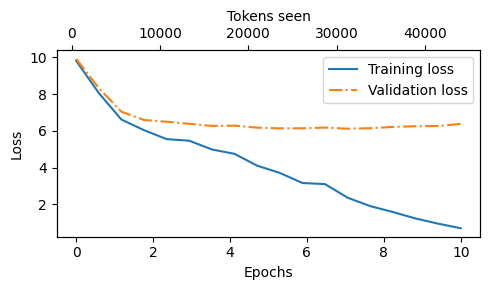

In [67]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


---
# Decoding Strategies to control randomness

## 1. Temperature Scaling

In [68]:
inference_device = torch.device('cuda')

model.to(inference_device)
model.eval()

token_ids = generate_text_simple(
    model=model,
    idx = text_to_token_ids("Every effor moves you", tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effor moves you know."
"I felt able to face the fact with a laugh: "Yes--and by me!"

He


In [69]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [70]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [71]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


In [72]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

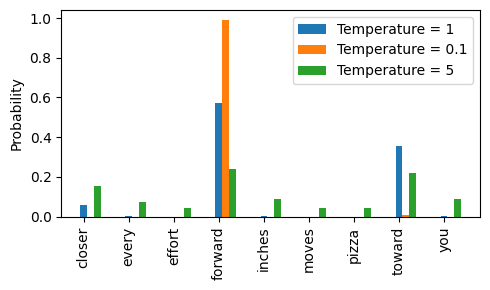

In [73]:
# Plotting
import matplotlib.pyplot as plt

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [74]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


In [75]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


## 2. Tok-k sampling

In [76]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500e+00, 6.2800e+00, 4.5100e+00])
Top positions: tensor([3, 7, 0])


In [77]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100e+00,       -inf,       -inf, 6.7500e+00,       -inf,       -inf,
              -inf, 6.2800e+00,       -inf])


In [78]:
# Alternate way

# Create tensor containing -inf values
new_logits = torch.full_like(next_token_logits, -torch.inf)
new_logits[top_pos] = next_token_logits[top_pos]
print(new_logits)

tensor([4.5100e+00,       -inf,       -inf, 6.7500e+00,       -inf,       -inf,
              -inf, 6.2800e+00,       -inf])


In [79]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([6.1485e-02, 0.0000e+00, 0.0000e+00, 5.7755e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.6097e-01, 0.0000e+00])


## 3. Combining Both

In [80]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)
        
        if temperature > 0.0:
            logits = logits / temperature
            logits = logits - logits.max(dim=-1, keepdim=True).values
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1) 

    return idx

In [81]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as terr what one of the axi," he that with a curious.



---
# Loading and Saving model weights in PyTorch

In [82]:
torch.save(model.state_dict(), "model.pth")

In [83]:
model = GPTModel(GPT_CONFIG_124M)

device = torch.device("cuda")

model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [84]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),},
    "model_and_optimizer.pth"
)

In [85]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features


---
# Loading Pre-Trained weights from OpenAI

In [86]:
from gpt_download import download_and_load_gpt2

2025-12-15 01:55:52.109585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765743952.161168    4742 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765743952.177845    4742 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765743952.298138    4742 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765743952.298172    4742 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765743952.298173    4742 computation_placer.cc:177] computation placer alr

In [87]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


2025-12-15 01:56:06.399202: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154389504 exceeds 10% of free system memory.


In [88]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [89]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape Mismatch")
    return torch.nn.Parameter(torch.tensor(right))

In [90]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.weight = assign(gpt.final_norm.weight, params["g"])
    gpt.final_norm.bias   = assign(gpt.final_norm.bias, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [91]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx = text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something happens

This would remove you from a battle


Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something happens

This would remove you from a battle





